In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [2]:
df = pd.read_csv('6.1_sales.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
Month    168 non-null object
Sales    168 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


In [4]:
df.tail()

,Month,Sales
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797
167,1975-12,843


In [5]:
df['Month'] = pd.to_datetime(df['Month'])

In [6]:
df.set_index('Month',inplace=True)

In [7]:
df.head()

,Sales
Month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [8]:
max_date = df.index.max()
min_date = df.index.min()
print(max_date)
print(min_date)

1975-12-01 00:00:00
1962-01-01 00:00:00


In [9]:
total_period_mths = ((max_date.year - min_date.year)*12 + (max_date.month - min_date.month)) + 1

In [10]:
#number of rows
len(df.index)

168

In [11]:
if total_period_mths == len(df.index):
    print("No Missing period")
    

No Missing period


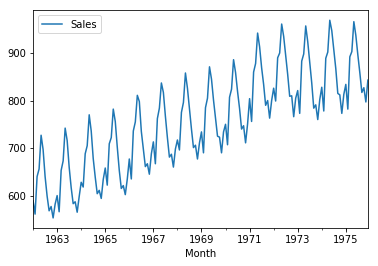

In [14]:
df.plot()
plt.show()

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [16]:
decomposition = seasonal_decompose(df,freq=12)

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 432x288 with 0 Axes>

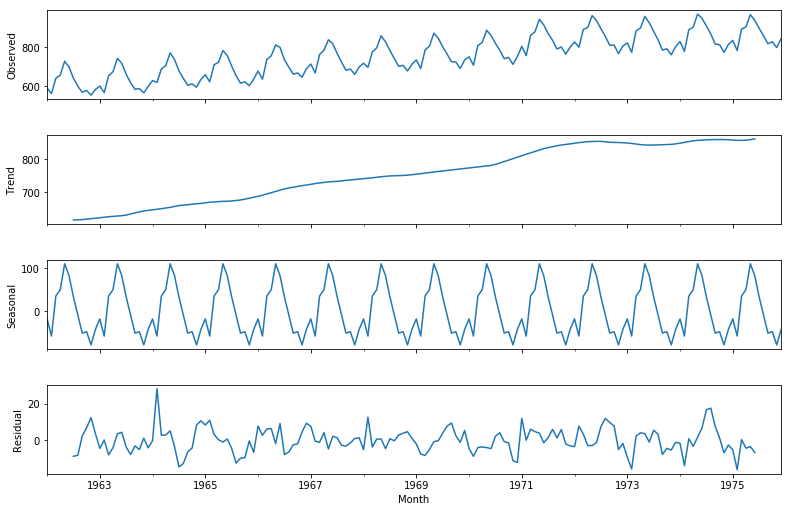

In [17]:
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(12,8)
fig.show()

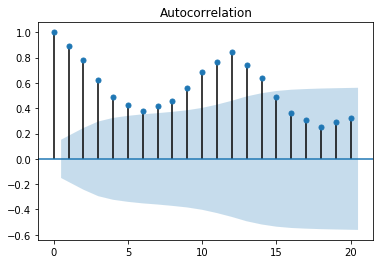

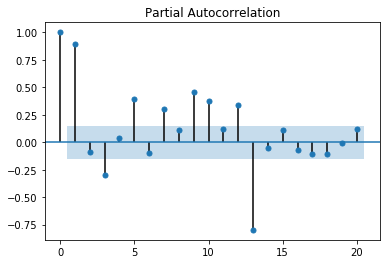

In [19]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['Sales'],lags=20,alpha=0.05);
plot_pacf(df['Sales'],lags=20,alpha=0.05);

## Stationarity Test - Augmented Dickey Fuller Test

In [21]:
from statsmodels.tsa.stattools import adfuller

In [25]:
adfuller(df['Sales'])

(-1.3038115874221246,
 0.627426708603034,
 13,
 154,
 {'1%': -3.473542528196209,
  '5%': -2.880497674144038,
  '10%': -2.576878053634677},
 1115.1730447395112)

##### Augmented Dickey Fuller Test
ADF Test Statistics: -1.30
 - p-value = 0.627
 - #Lags used: 13
 - No. of Observations used : 154
 - Null hypothesis holds: unit root, indicating it is non-stationary

In [26]:
df['Sales Seasosnal Diff'] = df['Sales'] - df['Sales'].shift(12)

In [29]:
adfuller(df['Sales Seasosnal Diff'].dropna())

(-2.3354193143593993,
 0.16079880527711304,
 12,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 983.7689056486297)

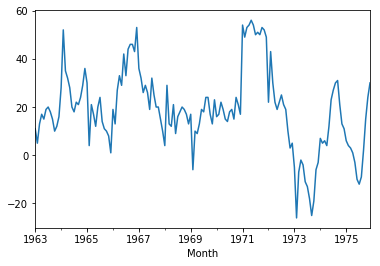

In [30]:
df['Sales Seasosnal Diff'].dropna().plot()

In [31]:
df['Seasonal First Difference'] = df['Sales Seasosnal Diff'] - df['Sales Seasosnal Diff'].shift(1)

In [32]:
adfuller(df['Seasonal First Difference'].dropna())

(-5.038002274921985,
 1.86542343187882e-05,
 11,
 143,
 {'1%': -3.4769274060112707,
  '5%': -2.8819726324025625,
  '10%': -2.577665408088415},
 980.3420381538448)

In [33]:
# Now the series has become stationary as p-value is less than 0.05, so we reject the null hypothesis

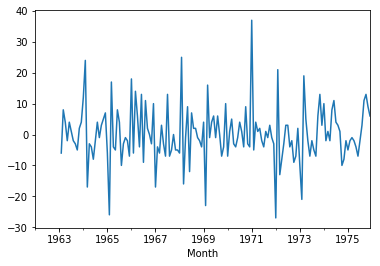

In [34]:
df['Seasonal First Difference'].plot()

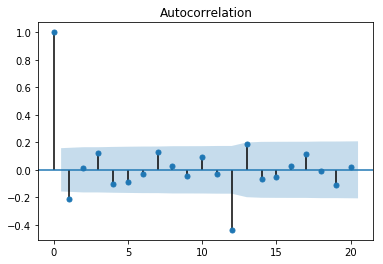

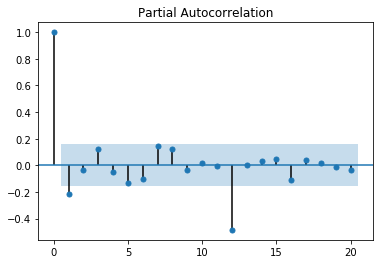

In [36]:
plot_acf(df['Seasonal First Difference'].dropna(),lags = 20,alpha=0.05);
plot_pacf(df['Seasonal First Difference'].dropna(),lags = 20,alpha=0.05);

## Estimation

In [38]:
df.index.freq = 'MS'
model = sm.tsa.statespace.SARIMAX(df['Sales'],order=(0,1,0),seasonal_order=(0,1,1,12))
results = model.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(0, 1, 1, 12)   Log Likelihood                -534.140
Date:                            Mon, 16 Dec 2019   AIC                           1072.280
Time:                                    16:47:55   BIC                           1078.367
Sample:                                01-01-1962   HQIC                          1074.752
                                     - 12-01-1975                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.6110      0.066     -9.285      0.000      -0.740      -0.482
sigma2        55.5966      5.322   

### Jarque-Bera Test: test for normality
-- Null Hypothesis: Not normally distributed

## Prediction  of Future Values

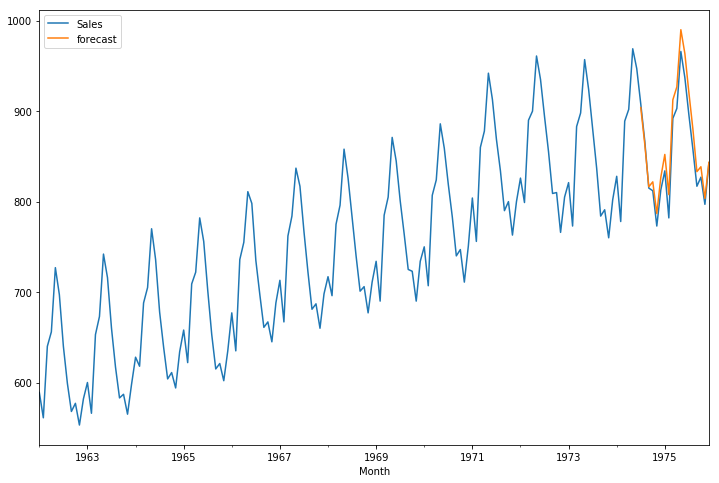

In [42]:
df['forecast'] = results.predict(start=150,end=168,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))